<a href="https://colab.research.google.com/github/sthalles/face-similarity/blob/master/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# if running locally, comment these lines
#!pip uninstall tensorflow
#!pip install tensorflow==1.10.1

In [14]:
import tensorflow as tf
import cv2
import os

print(tf.__version__)
tf.enable_eager_execution()

1.11.0


In [15]:
# if running locally, comment these lines
#!wget https://www.dropbox.com/s/4tjix8rhyzxpc28/dataset.tar.gz
#!wget https://www.dropbox.com/s/zj1v8n5href2mtu/tboard_logs.tar.gz
#!tar -xvzf dataset.tar.gz
#!tar -xvzf tboard_logs.tar.gz

In [16]:
# if running locally, comment these lines
#!mkdir src
#!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/contrastive.py
#!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/cyclical_lr.py
#!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/pre_processing.py
#!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/utils.py
#!mv contrastive.py ./src/
#!mv cyclical_lr.py ./src/
#!mv pre_processing.py ./src/
#!mv utils.py ./src/

In [17]:
# if running locally, comment these lines
#!mkdir model
#!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/model/densenet.py
#!mv densenet.py ./model/

In [18]:
import os
from model.densenet import DenseNet
from src.pre_processing import *
import matplotlib.pyplot as plt
from src.contrastive import contrastive_loss
import json
from src.utils import Dotdict

In [19]:
work_dir = './tboard_logs'
model_id = 31911
test_dataset_path = './dataset/test_v2.tfrecords'

In [20]:
checkpoint_dir = os.path.join(work_dir, str(model_id))

# load training metadata (setup path if necessary)
with open(checkpoint_dir + '/meta.json', 'r') as fp:
    training_args = Dotdict(json.load(fp))

In [21]:
tfe = tf.contrib.eager
test_filenames = [test_dataset_path]
test_dataset = tf.data.TFRecordDataset(test_filenames)
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.map(random_resize_and_crop)
test_dataset = test_dataset.map(normalizer)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(8)

In [22]:
args = {"k": training_args.growth_rate,
        "weight_decay": training_args.l2_regularization,
        "num_outputs": training_args.num_outputs,
        "units_per_block": training_args.units_per_block,
        "momentum": training_args.momentum,
        "epsilon": training_args.epsilon,
        "initial_pool": training_args.initial_pool}

model = DenseNet(**args)

In [23]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tfe.Checkpoint(model=model,
                      optimizer_step=tf.train.get_or_create_global_step())

try:
    root.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("Model {} successfully loaded.".format(model_id))
except:
    print("Error loading model: {}".format(FLAGS.model_id))

Model 31911 successfully loaded.


(8,)
Dw: tf.Tensor(
[2.7766178  2.6460738  2.311199   0.30269602 2.7871633  0.5866182
 1.0741255  1.9292692 ], shape=(8,), dtype=float32)


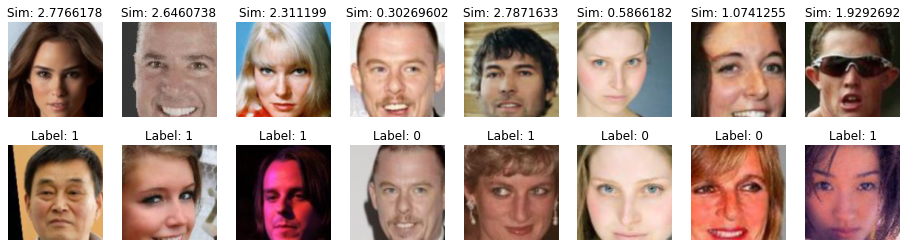

In [35]:
# ORGINAL DATASET

mean_similarity = []
mean_dissimilarity = []

for (batch, (Xi, Xj, label)) in enumerate(test_dataset):
    
    # print(Xi.shape)
    # print(Xj.shape) 
    # print(label.shape)    
    # print('Xi:', Xi)
    # print('Xi.dtype:', Xi.dtype)

    with tf.contrib.summary.record_summaries_every_n_global_steps(100):

        GX1 = model(Xi, training=False)
        GX2 = model(Xj, training=False)
        _, Dw = contrastive_loss(GX1, GX2, label, margin=2.)

        #print(Dw.shape)
        #print('Dw:', Dw)

        f, axarr = plt.subplots(2, 8, figsize=(16,4))
        f.subplots_adjust(hspace=0.3)

        for i in range(label.shape[0]):

            Si = denormalize(Xi[i]).numpy()
            Sj = denormalize(Xj[i]).numpy()

            if label[i].numpy() == 0:
                mean_similarity.append(Dw[i])
            else:
                mean_dissimilarity.append(Dw[i])

            axarr[0, i].set_title('Sim: ' + str(Dw[i].numpy()))
            axarr[0,i].imshow(np.squeeze(Si))
            axarr[0,i].set_axis_off()

            axarr[1,i].set_title("Label: " + str(label[i].numpy()))
            axarr[1,i].imshow(np.squeeze(Sj))
            axarr[1,i].set_axis_off()

        plt.show()

        break
    
    break

#mean_std_similarity_np = np.std(mean_similarity)
#mean_std_dissimilarity_np = np.std(mean_dissimilarity)
#mean_similarity_np = np.mean(mean_similarity)
#mean_dissimilarity_np = np.mean(mean_dissimilarity)

#print("Mean similarity {0} Mean Std: {1}.".format(mean_similarity_np, mean_std_similarity_np))
#print("Mean dissimilarity {0} Mean Std: {1}.".format(mean_dissimilarity_np, mean_std_dissimilarity_np))

In [25]:
def get_face(img):
    '''Crops image to only include face plus a border'''
    height, width, _ = img.shape
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face_box = face_cascade.detectMultiScale(img)
    # Get dimensions of bounding box
    x, y, w, h = tuple(map(tuple, face_box))[0]
    # Calculate padding as segmentation is too tight.
    pad_w = int(w / 2.5)
    pad_h = int(h / 2.5)
    # Get co-ordinates of crop
    x1 = max(0, x - pad_w)
    y1 = max(0, y - pad_h)
    x2 = min(width, x + w + pad_w)
    y2 = min(height, y + h + pad_h)
    # Crop image
    cropped = img[y1:y2, x1:x2]
    return cropped

InvalidArgumentError: slice index 7 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

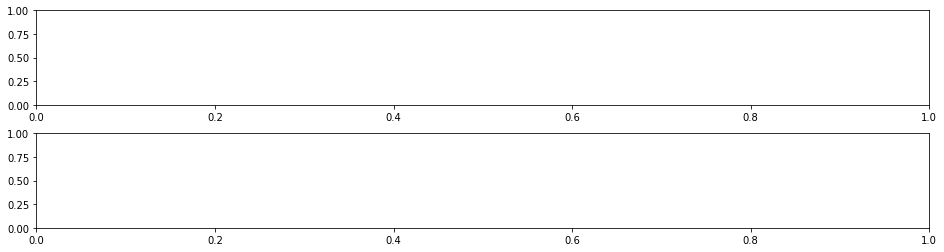

In [41]:
# Fill with yout own paths
save_dest = "D:\\Auditorium\\face-similarity\\cropped"

face_1 = get_face(cv2.imread(str("D:\\Auditorium\\OpenCV\\python-gender-age-detect\\test.png"), 1))
face_2 = get_face(cv2.imread(str("D:\\Auditorium\\OpenCV\\python-gender-age-detect\\test-2.png"), 1))

# Comparing two images
face_1_resized = cv2.resize(face_1, (128, 128))
face_2_resized = cv2.resize(face_2, (128, 128))

#Si = np.array(face_1_resized)
#Sj = np.array(face_2_resized)

cv2.imwrite(str(os.path.join(save_dest,'face_one.png')), face_1_resized)
cv2.imwrite(str(os.path.join(save_dest,'face_two.png')), face_2_resized)

Xi = np.array(face_1_resized, dtype='float32')
Xi /= 255.
Xi = np.expand_dims(Xi, 0)  # Add batch dimension.

Xj = np.array(face_2_resized, dtype='float32')
Xj /= 255.
Xj = np.expand_dims(Xj, 0)  # Add batch dimension.

label = np.array([1])
label[0] = 1

(Xi, Xj, label) = normalizer(Xi, Xj, label)

# print(Xi.shape)
# print(Xj.shape) 
# print(label.shape)   
#print('Xi:', Xi)
#print('Xi.dtype:', Xi.dtype)

with tf.contrib.summary.record_summaries_every_n_global_steps(100):

    GX1 = model(Xi, training=False)
    GX2 = model(Xj, training=False)
    _, Dw = contrastive_loss(GX1, GX2, label, margin=2.)

    #print(Dw.shape)
    #print('Dw:', Dw)

    f, axarr = plt.subplots(2, 1, figsize=(16,4))
    f.subplots_adjust(hspace=0.3)

    Si = denormalize(Xi[0]).numpy()
    Sj = denormalize(Xj[0]).numpy()

    axarr[0].set_title('Sim: ' + str(Dw[0].numpy()))
    axarr[0].imshow(np.squeeze(Si))
    axarr[0].set_axis_off()

    axarr[1].set_title("Label: " + str(label[0]))
    axarr[1].imshow(np.squeeze(Sj))
    axarr[1].set_axis_off()

    plt.show()